# Project: Finding Donors for a non-profit organization.

## **Problem Statement**:

Predict whether a candidate's income exceeds USD 50K/yr based on census data. This helps target candidates to reach out and request donation for a non-profit organization.

**Dataset used**:  
The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income).

## Project Planning:

1. Dataset Exploration and Null Hypothesis
2. Data PreProcessing
  * Handling Null Values
  * Handling Skewed Data
  * Feature Scaling
  * Encoding Categorical Features
3. Model Building
  * Dataset split into Train and Test sets
  * Naive Predictor's Performance
  * Choosing the Supervised Learning models
  * Fine tuning the high performance model using GridSearchCV

4. Analysis and Improvement
  * Analyzing the performance and identifying the most important features to challange Null Hypothesis.
  * Improving the model using the important features only.


### Imports



In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from time import time
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import visuals as vs

%matplotlib inline

----
## Step 1: Dataset Exploration and Null Hypothesis
  * 1.1 Data Exploration
  * 1.2 Null Hypothesis

### Step 1.1: Data Exploration


In [91]:
# Load the Census dataset
data = pd.read_csv(r'/content/drive/MyDrive/Udacity Projects/Charity ML/census.csv')

data.head()
data.shape

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


(45222, 14)

From the dataset, we can oberve the following about the types of features available.

Continuous Varaibles:
1. Age
2. education-num
3. capital-gain
4. capital-loss
5. hours-per-week

Categorical Variables:
1. workclass (8 unique values)
2. education (16 unique values)
3. marital-status (7 unique values)
4. occupation (14 unique values
5. relationship (6 unique values)
6. race (5 unique values)
7. sex (Binary - Male, Female)
8. native-country (42 unique values)

Target Variable:
  * income (Binary - <=50K, >50k)


In [92]:
n_records = data.shape[0]

n_greater_50k = data[data['income']=='>50K'].shape[0]

n_at_most_50k = data[data['income']=='<=50K'].shape[0]

greater_percent = (n_greater_50k *100)/n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(round(greater_percent,3)))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.8%


### Step 1.2: Null Hypothesis

Hypothesizing that the following 5 features are important for classifying the income of the candidate:  
#### 1. Capital Gain
#### 2. Capital Loss
#### 3. Occupation
#### 4. Education
#### 5. Country

#### **Why?**
- Higher the capital gain from their business, higher the money people get which might be responsible for income > 50k.
- Similarly, more the capital loss, less likely to have income <50k.
- Occupation including managerial positions generally get paid more.
- Highly educated people mostly end up in highly paid jobs.
- Salary varies country by country where demand is higher. For exapmle, people working in US might get paid more than a person working in India for the same job role/occupation.

----
## Step 2: Data PreProcessing  
- 2.1 Handling Null Values  
- 2.2 Handling Skewed Data
- 2.3 Feature Scaling
- 2.4 Encoding Categorical Features

This dataset doesn't contain invalid entries to deal with. 


### 2.1 Handling Null Values

In [93]:
data.isna().sum(axis=0)

# This dataset does not contain Null values.

age                0
workclass          0
education_level    0
education-num      0
marital-status     0
occupation         0
relationship       0
race               0
sex                0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

### 2.2 Handling Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 


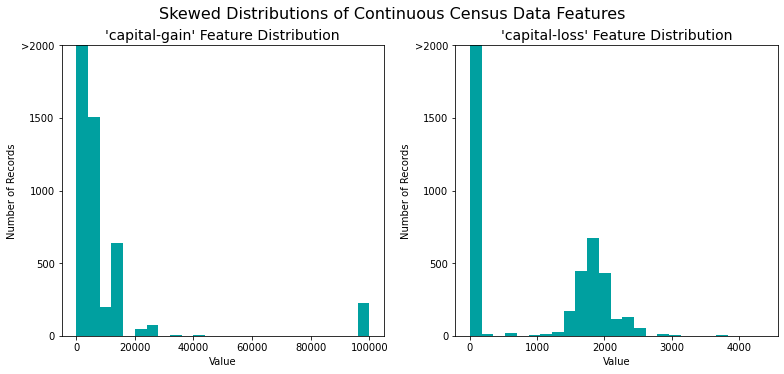

In [94]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

**Discussion 2.2:**  
Features `'capital-gain'` and `'capital-loss'` are highly skewed. Logarithmic transformation can be applied on the data so that the very large and very small values do not negatively affect the performance of the learning algorithm. 

Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so the values must be translated by a small amount above `0` to apply the the logarithm successfully.


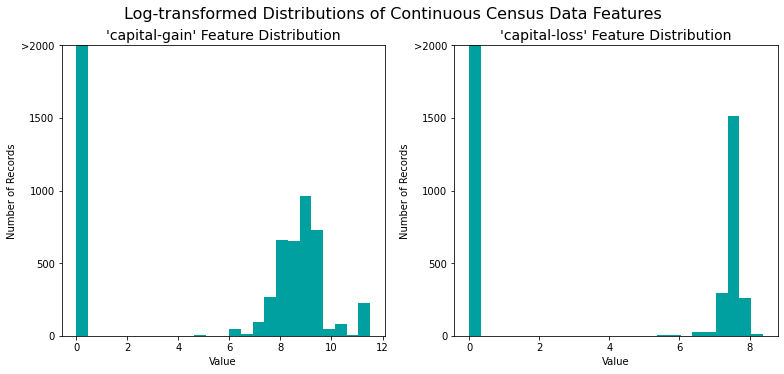

In [95]:
# Log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Step 2.3: Feature Scaling - Normalizing Numerical Features

Normalization ensures that each feature is treated equally when applying supervised learners.

In [96]:
# Initializing a scaler object
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

# Scaling the features using the scaler object
features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

features_log_minmax_transform.head()
features_log_minmax_transform.shape

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


(45222, 13)

### Step 2.4: Encoding Categorical Features

Typically, learning algorithms expect input to be numeric, which requires that categorical features be converted to encoded numerical features. One popular way to do so is by using the **one-hot encoding** scheme. 


In [97]:
# One-hot encoding the features
features_final = pd.get_dummies(features_log_minmax_transform)

# Encoding the Target variable to numerical values
income = income_raw.map({'>50K':1, '<=50K':0})


features_final.head()
features_final.shape

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


(45222, 103)

----
## Step 3: Model Building
- 3.1 Shuffle and Split Data
- 3.2 Observing the Naive Predictor's Performance
- 3.3 Supervised Learning Models 

### Step 3.1: Shuffle and Split Data
Splitting the data into Train, Test and Validation Sets

In [98]:
# Splitting the features and target data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Size of Training and Testing datasets after the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.



### Step 3.2: Observing the Naive Predictor's Performance

In this section, we will investigate the performance of a Naive Predictor which predicts are same outcome for all the datapoints.

Let's assume that a Naive Predictor predictes all the individuals made more than $50,000, what would  that model's accuracy and F-score be on this dataset? 

In [99]:
# Calculating accuracy, precision and recall
TP = (income[income==1].shape[0])
FP = (income[income==0].shape[0])
FN = 0
TN = 0

accuracy = (TP+TN)/income.shape[0]
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# Calculating F-score using the formula with Beta=0.5.
fscore = (1.5*precision*recall)/((0.25*precision)+recall)

# Printing the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.3501]


### Step 3.3: Supervised Learning Models
- 3.3.1 Choosing the Supervised Learning models
- 3.3.2 Initial Models' Evaluation
- 3.3.3 Fine Tuning the best model


#### Step 3.3.1:
**The following algorithms are used for the supervised learning task that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html):

- Logistic Regression
- Support Vector Machines(SVM)
- Random Forest
- Gradient Boosting

In [100]:
# Creating a pipeline function to evaluate the model performance

def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted with
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    # Calculating the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test) and train set(X_train)

    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # Calculating the total prediction time
    results['pred_time'] = end-start
            
    # Computing accuracy and F0.5 score for Training and Testing data
    results['acc_train'] = accuracy_score(predictions_train, y_train)
    results['acc_test'] = accuracy_score(predictions_test, y_test)

    results['f_train'] = fbeta_score(y_train, predictions_train, beta=0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
      

    print("{} model is trained.".format(learner.__class__.__name__))
        
    # Return the results
    return results

#### Step 3.3.2  Initial Models' Evaluation


In [101]:
# Creating a Visualization Function

def evaluate_with_naive(results, accuracy, f1):
  '''
  inputs:
    - results: Dictionary of Performance Metrics for each Supervised Learning Model
    - accuracy: Accuracy score of the Naive Predictor
    - f1: f1 score of the Naive Predictor
  '''
  fig, ax = pl.subplots(2, 3, figsize = (12,7))

  bar_width = 0.3
  colors = ['#A00000','#00A0A0','#00A000', '#800080']

  for k, learner in enumerate(results.keys()):
      for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):

        # Creative plot code
        ax[j//3, j%3].bar(k*bar_width, results[learner][metric], width = bar_width, color = colors[k])

  # Adding unique y-labels
  ax[0, 0].set_ylabel("Time (in seconds)")
  ax[0, 1].set_ylabel("Accuracy Score")
  ax[0, 2].set_ylabel("F-score")
  ax[1, 0].set_ylabel("Time (in seconds)")
  ax[1, 1].set_ylabel("Accuracy Score")
  ax[1, 2].set_ylabel("F-score")

  # Adding titles
  ax[0, 0].set_title("Model Training")
  ax[0, 1].set_title("Accuracy Score on Training Subset")
  ax[0, 2].set_title("F-score on Training Subset")
  ax[1, 0].set_title("Model Predicting")
  ax[1, 1].set_title("Accuracy Score on Testing Set")
  ax[1, 2].set_title("F-score on Testing Set")

  # Adding horizontal lines for naive predictors
  ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
  ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
  ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
  ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')

  # Creating patches for the legend
  patches = []
  for i, learner in enumerate(results.keys()):
    patches.append(mpatches.Patch(color = colors[i], label = learner))
    pl.legend(handles = patches, bbox_to_anchor = (-.80, 2.7), loc = 'upper center', borderaxespad = 0., ncol = 3, fontsize = 'x-large')

  pl.suptitle("Performance Metrics for Supervised Learning Models", fontsize = 16, y = 1.10)
  pl.tight_layout()
  pl.show()

LogisticRegression model is trained.
RandomForestClassifier model is trained.
GradientBoostingClassifier model is trained.
SVC model is trained.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


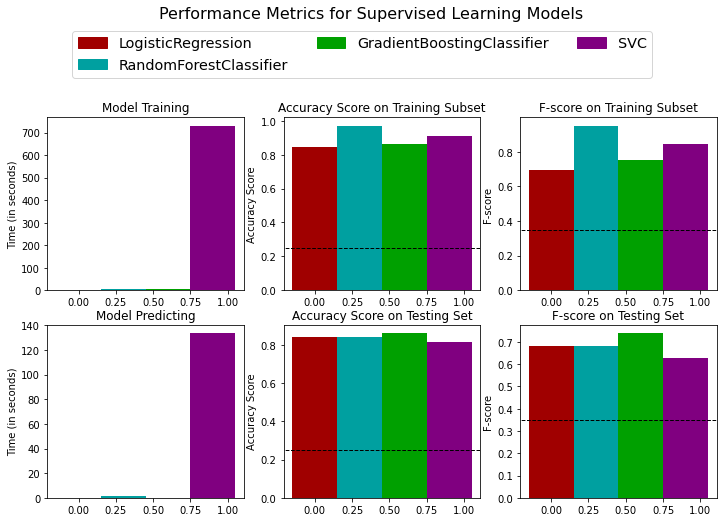

In [102]:

# Initializing the three Baseline models
clf_LR = LogisticRegression(max_iter=1000)
clf_RFC = RandomForestClassifier()
clf_GBC = GradientBoostingClassifier()
clf_SVC = SVC(C=1.5, kernel='rbf', degree=4, gamma=30)

# Collecting results on the learners
results = {}
for clf in [clf_LR, clf_RFC, clf_GBC, clf_SVC]:
  clf_name = clf.__class__.__name__
  results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)
        

# Run metrics visualization for the three chosen supervised learning models

evaluate_with_naive(results, accuracy, fscore)

# The black dash line indicates the performance of the Naive predictor we used earlier.

In [103]:
results

{'GradientBoostingClassifier': {'acc_test': 0.8630182421227197,
  'acc_train': 0.865743428144954,
  'f_test': 0.7395338561802719,
  'f_train': 0.7530470502391698,
  'pred_time': 0.15819787979125977,
  'train_time': 6.898761749267578},
 'LogisticRegression': {'acc_test': 0.8417910447761194,
  'acc_train': 0.8431876606683805,
  'f_test': 0.6829293664828877,
  'f_train': 0.6946344233101918,
  'pred_time': 0.013692378997802734,
  'train_time': 2.6582186222076416},
 'RandomForestClassifier': {'acc_test': 0.8416804864566059,
  'acc_train': 0.9725239793238798,
  'f_test': 0.679774725817607,
  'f_train': 0.9517648394052888,
  'pred_time': 1.375856637954712,
  'train_time': 5.371832847595215},
 'SVC': {'acc_test': 0.8176893311221669,
  'acc_train': 0.9127622522597231,
  'f_test': 0.6264760720944687,
  'f_train': 0.8457100773290781,
  'pred_time': 133.76254844665527,
  'train_time': 731.8075170516968}}

----
### Step 3.3.3 Fine Tuning the Best Model
Now that we have observed and chosen the best model, let's perform a grid search optimization for that model over the entire training set (`X_train` and `y_train`) by tuning it's parameters to improve upon the untuned model's F-score. 

In [104]:

clf = GradientBoostingClassifier()
parameters = {'n_estimators': [100, 200, 300],
              'max_depth':[3,4,5],
              'min_samples_split': [2,4,6,8,10]}

scorer = make_scorer(fbeta_score, beta=0.5)

grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)
grid_fit = grid_obj.fit(X_train, y_train)
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized model to compare
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the optimized and unoptimized model scores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8704
Final F-score on the testing data: 0.7520


In [105]:
best_clf

GradientBoostingClassifier(max_depth=4, min_samples_split=8, n_estimators=200)

----
### Step 4: Analysis and Improvement
- 4.1 Feature Importance
- 4.2 Feature Selection and Evaluation

#### Step 4.1: Feature Importance

In this section, the above model is further tried to improve by choosing the most important features. With these features, we will also challenge the Null Hypothesis we had in Step 1.2.   

Let's identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Text(0.5, 1.0, 'Normalized Weights for First Five Most Predictive Features')

<BarContainer object of 5 artists>

<BarContainer object of 5 artists>

([<matplotlib.axis.XTick at 0x7f1503f4f4d0>,
 [Text(0, 0, 'marital-status_ Married-civ-spouse'),
  Text(0, 0, 'capital-gain'),
  Text(0, 0, 'education-num'),
  Text(0, 0, 'capital-loss'),
  Text(0, 0, 'age')])

(-0.5, 4.5)

Text(0, 0.5, 'Weight')

Text(0.5, 0, 'Feature')

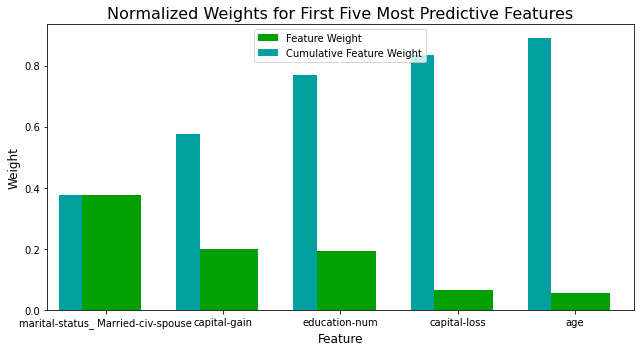

In [106]:
# Extracting the important features
importances = best_clf.feature_importances_

# Fetching the 5 most important features
indices = np.argsort(importances)[::-1]
columns = X_train.columns.values[indices[:5]]
values = importances[indices][:5]

# Plotting the features and their respective weights
fig = pl.figure(figsize = (9,5))
pl.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
pl.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
      label = "Feature Weight")
pl.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
      label = "Cumulative Feature Weight")
pl.xticks(np.arange(5), columns)
pl.xlim((-0.5, 4.5))
pl.ylabel("Weight", fontsize = 12)
pl.xlabel("Feature", fontsize = 12)

pl.legend(loc = 'upper center')
pl.tight_layout()
pl.show()  


### Discussion 4.1:

As it can be oberved, the following 5 features are the most important in prediction.
- marital-status_ Married-civ-spouse
- capital-gain
- education-num
- capital-loss
- age

Features Capital Gain, Capital Loss and Education are the same as the features in Null Hypothesis. However, Marital Status and Age were not in the Null Hypothesis. 
These 2 features make sense because, mostly high earners are older in age (40's to 50's) and majority of young candidates earn less as they are in the start of their career. Also, these high earners are most likely to be married and living with their Spouse.

#### 4.2: Feature Selection and Evaluation
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of all features present in the data. This hints that we can attempt to reduce the feature space and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set with only the top five important features.

In [107]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Choosing only the 5 important features identified earlier
X_train_reduced = X_train[columns]
X_test_reduced = X_test[columns]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8704
F-score on testing data: 0.7520

Final Model trained on reduced data
------
Accuracy on testing data: 0.8593
F-score on testing data: 0.7256


### Discussion 4.2 - Effects of Feature Selection


### Answer 8
- The F-score and accuracy of the final model trained with important features reduced a bit compared to the model trained with all features. Accuracy reduced by  1.28% and F-score reduced by 3.5% to be precise.

- Though it feels tempting to suggest using the data with only the important features. Considering the small training time and the availability of resources, it's better to get that minimal improvement by going with all features.

# Thank You